# Imputation Analysis

In [247]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer
from xgboost import XGBClassifier

def fb_score(y_true, y_pred, beta):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return ((1 + beta**2) * precision * recall) / ((beta**2) * precision + recall)

def f1_func(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall)

def f2_func(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return (5 * precision * recall) / (4 * precision + recall)

def classification_results(y_true, y_pred, verbose=0):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_func(y_true, y_pred)
    f2 = f2_func(y_true, y_pred)
    if verbose:
        results = [
            ("accuracy", accuracy), 
            ("precision", precision),
            ("recall", recall),
            ("f1", f1),
            ("f2", f2),
        ]
        print("\nCLASSIFICATION METRICS:\n")
        for (metric, score) in results:
            print(f"{metric} = {score:.2f}")
        print("\n")
    else:
        results = [accuracy, precision, recall, f1, f2]
    return results

f1_score = make_scorer(f1_func)
f2_score = make_scorer(f2_func)

base_dir = os.path.join(os.getcwd(), os.pardir)

Get the data

In [5]:
impute_dir = os.path.join(base_dir, "data/altered/imputed")
mf_dir = os.path.join(impute_dir, "multiple/missforest")
impute_paths = [(name[5:-4], os.path.join(impute_dir, name)) for name in os.listdir(impute_dir) if name[-4:] == ".csv"]
mf_paths = [(name[:-4], os.path.join(mf_dir, name)) for name in os.listdir(mf_dir)]
impute_paths += mf_paths
all_imputations = [(name, pd.read_csv(path, index_col=0)) for (name, path) in impute_paths]

Sort imputed dataframes

In [6]:
imputations = []
imputations_to_use = [
    "meanmode_impute", 
    "hotdeck_impute", 
    "linlog_reg_impute", 
    "stochastic_linlog_reg_impute", 
    "randomforest_impute", 
    "xgboost_impute",
    "missforest_imputation_1"
]

for (name, df) in all_imputations:
    if name in imputations_to_use:
        if name == "missforest_imputation_1":
            name = "iterative_randomforest"
        else:
            name = name[:-7]
        imputations.append((name, df))

## Classification of deppresion diagnosis

Create a test set from the original data

In [7]:
orig_path = os.path.join(base_dir, "data/altered/maps_feature_mapping.csv")
orig_df = pd.read_csv(orig_path, index_col="X")

orig_X = df.drop(["has_dep_diag"], axis=1)
orig_y = df["has_dep_diag"]

orig_X_train, orig_X_test, orig_y_train, orig_y_test = train_test_split(orig_X, orig_y, random_state=42)

Create list for storing classification results.

In [9]:
clf_results = []

Train base XGBoost classifier without imputations.

In [10]:
xgb = XGBClassifier(objective="binary:logistic")
xgb.fit(orig_X_train, orig_y_train)
score = xgb.score(orig_X_test, orig_y_test)

clf_results.append(("without imputation", score))

print(f"\nXGBoost classification score on non-imputed data: {score}")

[19:24:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

XGBoost classification score on non-imputed data: 1.0


Train XGBoost classifier on each imputed dataset.

In [11]:
for (name, df) in imputations:

    X = df.drop("has_dep_diag", axis=1)
    y = df["has_dep_diag"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    xgb = XGBClassifier(objective="binary:logistic")
    xgb.fit(X_train, y_train)
    score = xgb.score(orig_X_test, orig_y_test)

    clf_results.append((name, score))

/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[19:25:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:25:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was c

Plot results

<AxesSubplot:xlabel='classification_accuracy', ylabel='imputation_method'>

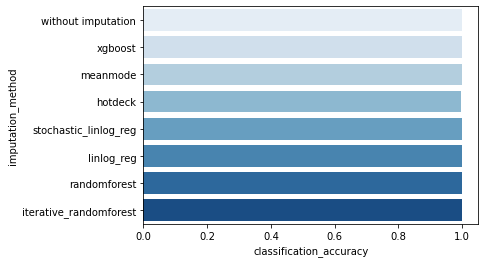

In [12]:
plt_df = pd.DataFrame(clf_results, columns=["imputation_method", "classification_accuracy"])

sns.barplot(x="classification_accuracy", y="imputation_method", data=plt_df, palette="Blues")

## Classification with reduced feature set

Results are likely too accurate due to many other medical features such as `dep_score` and `dep_band` being so closely related.

Let's remove any depression and anxiety related features.

In [217]:
target_feature = ["has_dep_diag"]
non_med_features = [
    "comp_bed_9", "mat_age", "weight_16", "height_16", "iq",
    "comp_noint_bed_16", "comp_int_bed_16", "talk_phon_wend", 
    "text_wend", "talk_mob_wend", "comp_wend", "musi_wend", 
    "read_wend", "work_wend", "alon_wend", "draw_wend", 
    "play_wend", "tv_wend", "out_win_wend", "out_sum_wend", 
    "tran_wend", "talk_phon_week", "text_week", "talk_mob_week", 
    "comp_week", "musi_week", "read_week", "work_week", 
    "alon_week", "draw_week", "play_week", "tv_week", 
    "out_win_week", "out_sum_week", "tran_week", "pat_pres_10", 
    "pat_pres_8", "pat_pres", "num_home", "pat_ses", "mat_ses", 
    "pat_edu", "mat_edu", "parity", "exercise", "child_bull", 
    "phone_14_wend", "phone_14_week", "musi_13", "tv_bed_9", 
    "own_mob", "comp_house", "tv_bed_16", "creat_14", "comp_games", 
    "fam_tv_eve", "fam_tv_aft", "fam_tv_mor", "sex", "birth_order"
]

non_med_feature_cols = [orig_df.columns.get_loc(feature) for feature in non_med_features]
target_feature_col = orig_df.columns.get_loc(target_feature[0])

reduced_df = orig_df[non_med_features + target_feature].copy()

# remove rows with missing values in target feature
notnull_idxs = reduced_df["has_dep_diag"].notnull()
reduced_df = reduced_df[notnull_idxs]

reduced_X = reduced_df.drop(["has_dep_diag"], axis=1)
reduced_y = reduced_df["has_dep_diag"]

reduced_X_train, reduced_X_test, reduced_y_train, reduced_y_test = train_test_split(reduced_X, reduced_y, stratify=reduced_y, random_state=42)
X_test, y_test = reduced_X_test, reduced_y_test

# get test and train indexs
test_idxs = y_test.index.tolist()
# train_idxs = [idx for idx in orig_df.index.tolist() if not idx in test_idxs]
train_idxs = y_train.index.tolist()

# fix indexes to start at 0 for np array
np_test_idxs = [x - 1 for x in test_idxs]
np_train_idxs = [x - 1 for x in train_idxs]

Get the ratio of negatives to positive classes.

In [230]:
counts = y_test.value_counts()
sample_ratio = counts[0]/counts[1]
sample_ratio

10.639175257731958

Train xgb on non-imputed data as base results.

In [248]:
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=sample_ratio,
)

xgb.fit(reduced_X_train, reduced_y_train)

preds = xgb.predict(X_test)
results = classification_results(y_test, preds)

reduced_clf_results = []
reduced_clf_results.append(["without imputation"] + results)

print(f"\nMetrics for non-imputed data: {results}")

/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

Metrics for non-imputed data: [0.9025686448184234, 0.21739130434782608, 0.05154639175257732, 0.08333333333333333, 0.0608272506082725]


Now lets compare with the imputed datasets.

In [249]:
for (name, df) in imputations:
    # arr = df.to_numpy()
    # X = arr[:, non_med_feature_cols]
    # y = arr[:, target_feature_col]
    # X_train = pd.DataFrame(X[np_train_idxs], columns=non_med_features)
    # y_train = pd.DataFrame(y[np_train_idxs], columns=target_feature)

    X = df[non_med_features]
    y = df[target_feature]

    # fix for rf imputation having indexes starting at 0
    if name == "iterative_randomforest":
        X_train, y_train = X.loc[np_train_idxs], y.loc[np_train_idxs]
    else:
        X_train, y_train = X.loc[train_idxs], y.loc[train_idxs]

    xgb = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        scale_pos_weight=sample_ratio,
    )
    xgb.fit(X_train, y_train)

    preds = xgb.predict(X_test)
    results = classification_results(y_test, preds)
    reduced_clf_results.append([name] + results)

/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Plot the results

In [296]:
columns=["Accuracy", "Precision", "Recall", "F1-Score", "F2-Score"]
idxs=["Without Imputation", "XGBoost", "Mean / Mode", "Hot-Deck", "Stochastic Regression", "Regression", "Random Forest", "Iterative Random Forest"]
results_df = pd.DataFrame(np.asarray(reduced_clf_results)[:,1:], columns=columns, index=idxs).astype(float)

results_df

,Accuracy,Precision,Recall,F1-Score,F2-Score
Without Imputation,0.902569,0.217391,0.051546,0.083333,0.060827
XGBoost,0.966342,0.873418,0.711340,0.784091,0.738758
Mean / Mode,0.953056,0.940000,0.484536,0.639456,0.536530
Hot-Deck,0.513729,0.107639,0.639175,0.184250,0.321577
Stochastic Regression,0.902569,0.413333,0.319588,0.360465,0.334773
Regression,0.949513,0.954545,0.432990,0.595745,0.486111
Random Forest,0.945970,0.833333,0.463918,0.596026,0.509050
Iterative Random Forest,0.948627,0.975610,0.412371,0.579710,0.466200


<AxesSubplot:title={'center':'Classification Metrics of Depression Diagnosis Using Imputed Datasets'}>

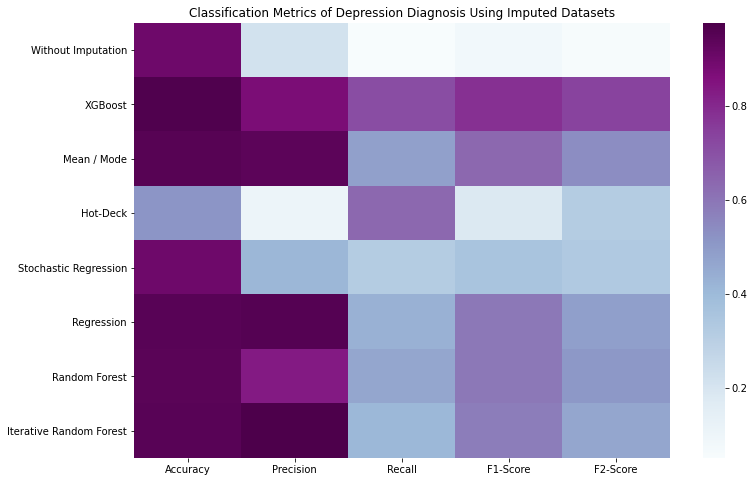

In [297]:
plt.figure(figsize=(12,8))
plt.title("Classification Metrics of Depression Diagnosis Using Imputed Datasets")
sns.heatmap(results_df, cmap="BuPu")